In [4]:
# Import Libraries

import random
from matplotlib import style
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.random.seed(42)

style.use('fivethirtyeight')


In [5]:
data_dir = Path('../../GTSRB/')
train_path = Path('../../GTSRB/Train/')
test_path = Path('../../GTSRB/Test/')

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3


In [6]:
NUM_CATEGORIES = len(list(train_path.iterdir()))
print(NUM_CATEGORIES)


43


In [7]:
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}


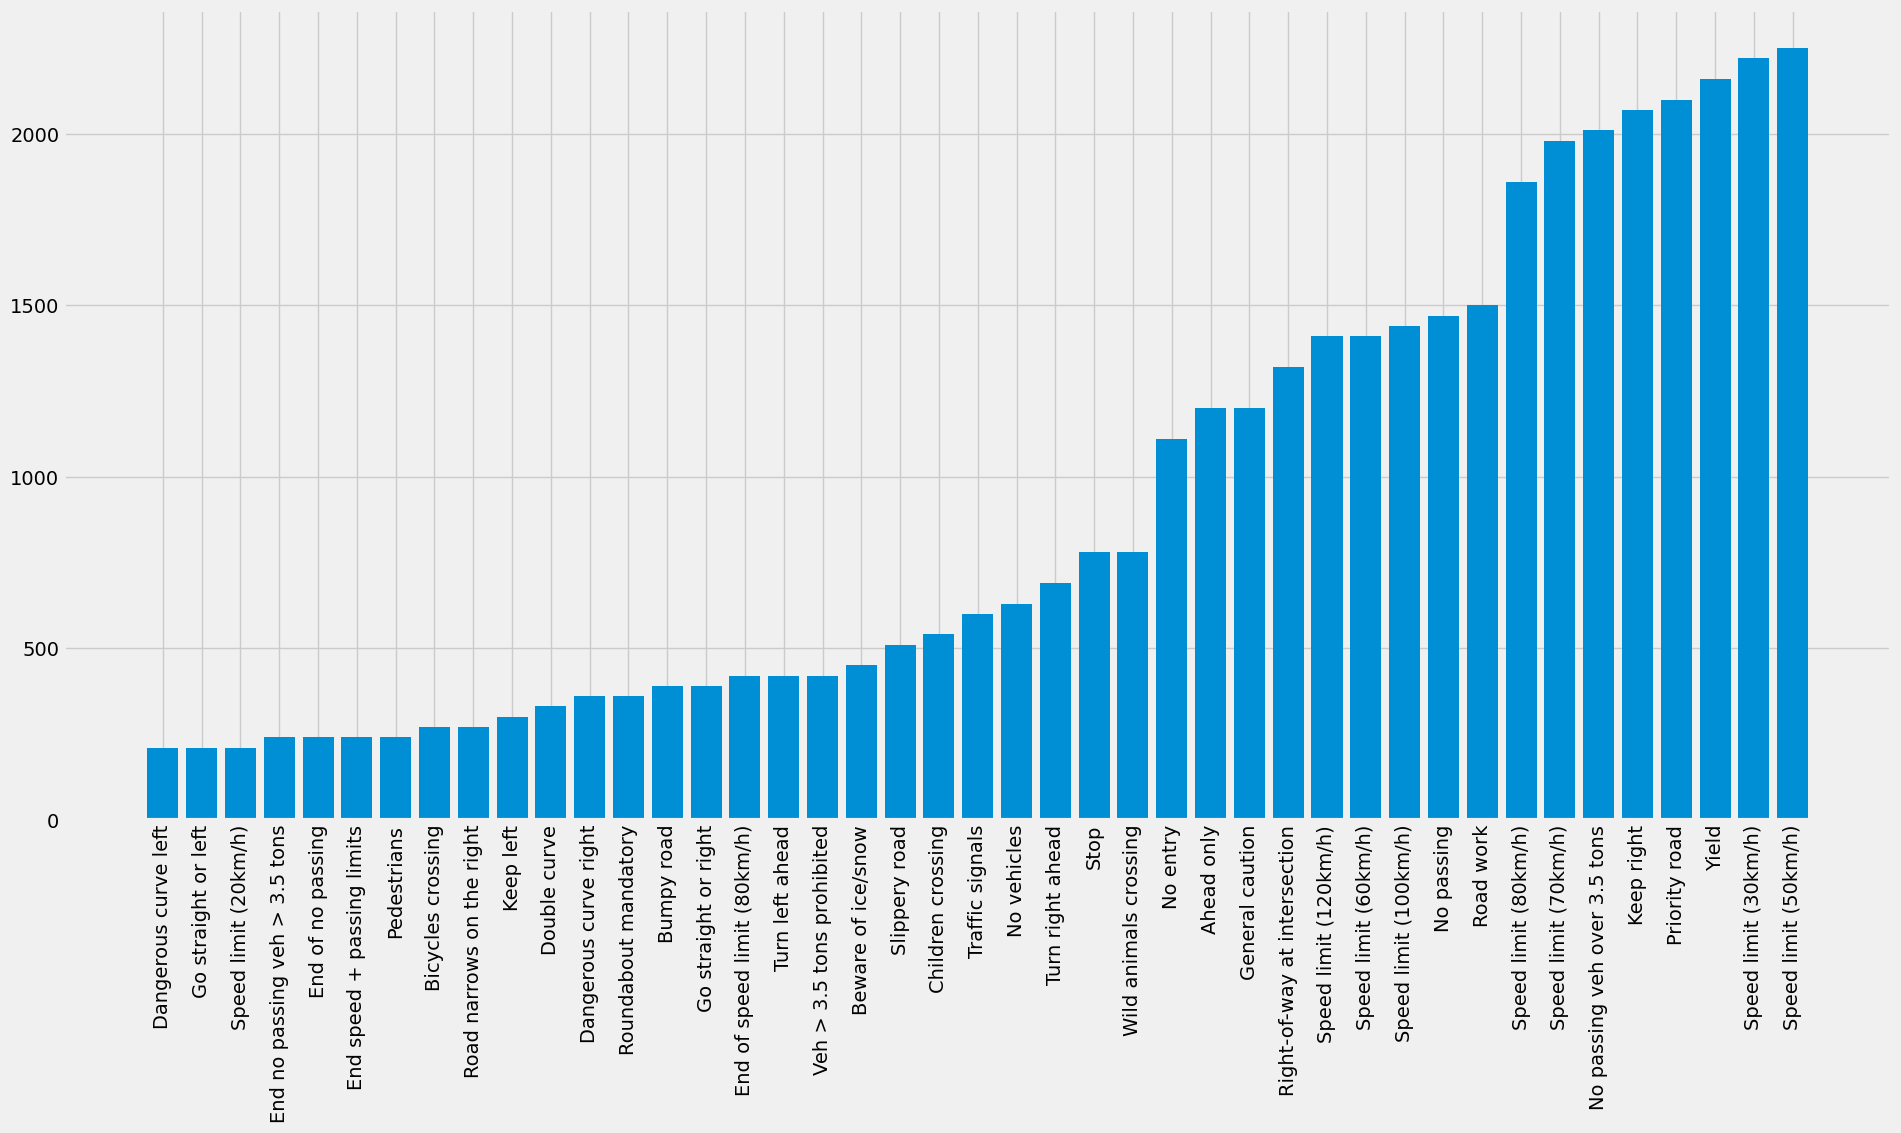

In [8]:
train_number = []
class_num = []

for folder in train_path.iterdir():
    train_number.append(len(list(folder.iterdir())))
    class_num.append(classes[int(folder.name)])

sorted_pairs = sorted(zip(train_number, class_num))
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()


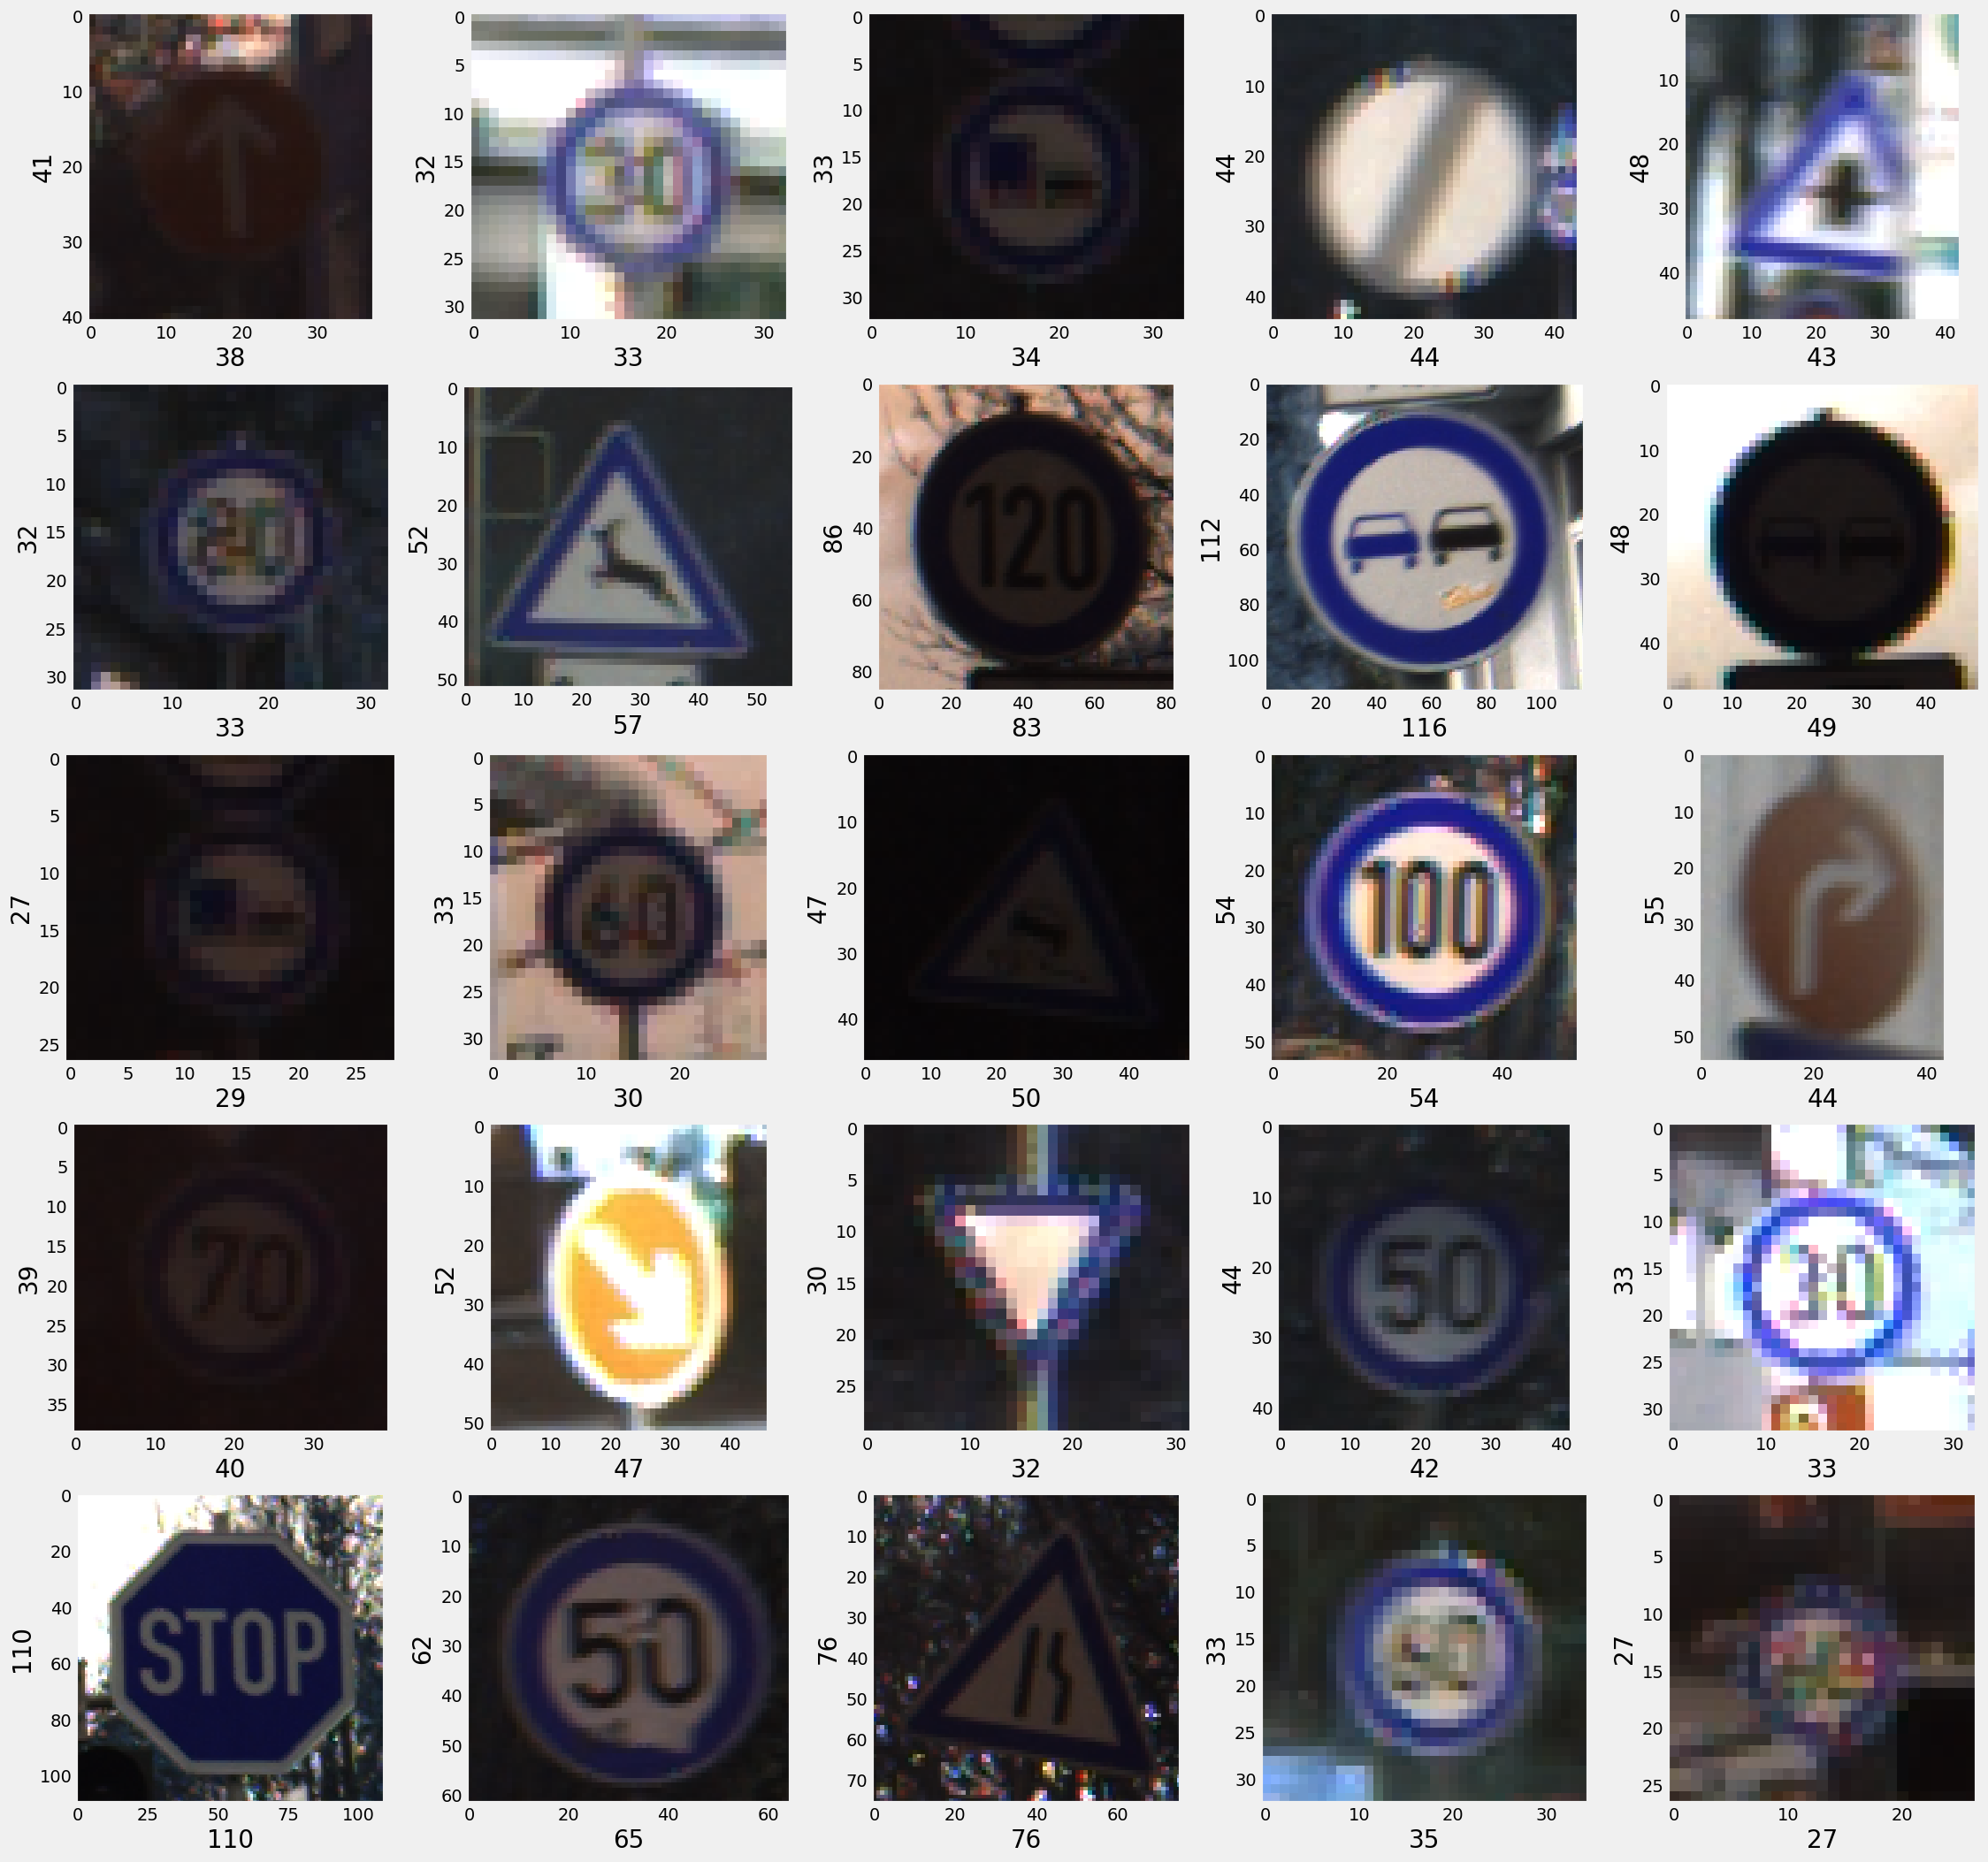

In [9]:
test = pd.read_csv(data_dir.joinpath("Test.csv"))
imgs = test['Path'].values

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    rand_img = str(random.choice(imgs))
    rand_img = cv2.imread(str(data_dir) + '/' + rand_img)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(str(rand_img.shape[1]), fontsize=20)  # width of image
    plt.ylabel(str(rand_img.shape[0]), fontsize=20)  # height of image


In [10]:
image_data = []
image_labels = []

for folder in train_path.iterdir():
    for img in folder.iterdir():
        try:
            image = cv2.imread(str(img))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resize_image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(folder.name)
        except Exception as e:
            print(e)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)


(39209, 30, 30, 3) (39209,)


In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train / 255
X_val = X_val / 255

print("X_train.shape: ", X_train.shape)
print("X_valid.shape: ", X_val.shape)
print("y_train.shape: ", y_train.shape)
print("y_valid.shape: ", y_val.shape)


X_train.shape:  (27446, 30, 30, 3)
X_valid.shape:  (11763, 30, 30, 3)
y_train.shape:  (27446,)
y_valid.shape:  (11763,)


In [13]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(
        3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])


In [15]:
lr = 0.001
epochs = 30

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              


                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 128)         0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 4, 4, 128)         512       
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 2048)              0         
          

In [16]:
aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 58s 66ms/step - loss: 1.1034 - accuracy: 0.6991 - val_loss: 0.0903 - val_accuracy: 0.9720
Epoch 2/30
858/858 [==============================] - 52s 60ms/step - loss: 0.1992 - accuracy: 0.9391 - val_loss: 0.0312 - val_accuracy: 0.9902
Epoch 3/30
858/858 [==============================] - 54s 62ms/step - loss: 0.1176 - accuracy: 0.9649 - val_loss: 0.0144 - val_accuracy: 0.9957
Epoch 4/30
858/858 [==============================] - 54s 63ms/step - loss: 0.0818 - accuracy: 0.9752 - val_loss: 0.0233 - val_accuracy: 0.9924
Epoch 5/30
858/858 [==============================] - 50s 58ms/step - loss: 0.0722 - accuracy: 0.9775 - val_loss: 0.0354 - val_accuracy: 0.9895
Epoch 6/30
858/858 [==============================] - 57s 66ms/step - loss: 0.0591 - accuracy: 0.9819 - val_loss: 0.0182 - val_accuracy: 0.9948
Epoch 7/30
858/858 [==============================] - 51s 60ms/step - loss: 0.0504 - accuracy: 0.9840 - val_loss: 0.0446 - val_accuracy:

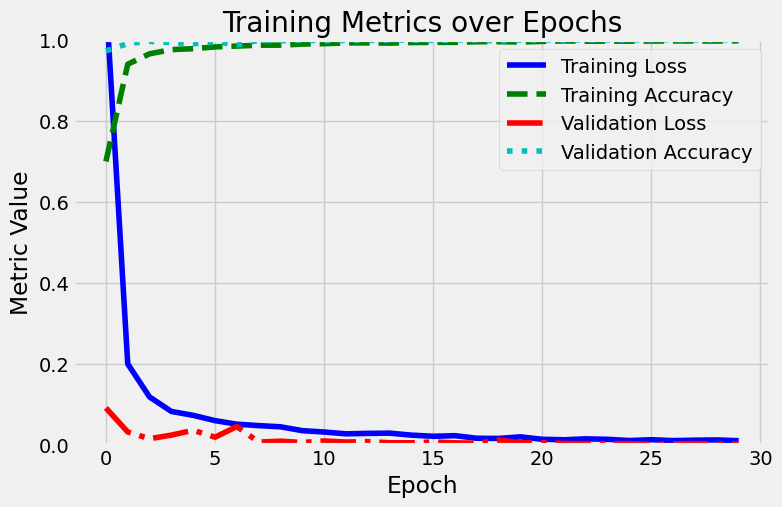

In [17]:
# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# plt.gca().set_ylim(0, 1)
# plt.show()


history_df = pd.DataFrame(history.history)
ax = history_df.plot(figsize=(8, 5), style=['b-', 'g--', 'r-.', 'c:'])
ax.set_title('Training Metrics over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric Value')
ax.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'], loc='upper right')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
test = pd.read_csv(str(data_dir.joinpath('Test.csv')))

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(str(data_dir) + '/' + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test / 255

pred = np.argmax(model.predict(X_test),axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 4s 10ms/step
Test Data accuracy:  98.09976247030879


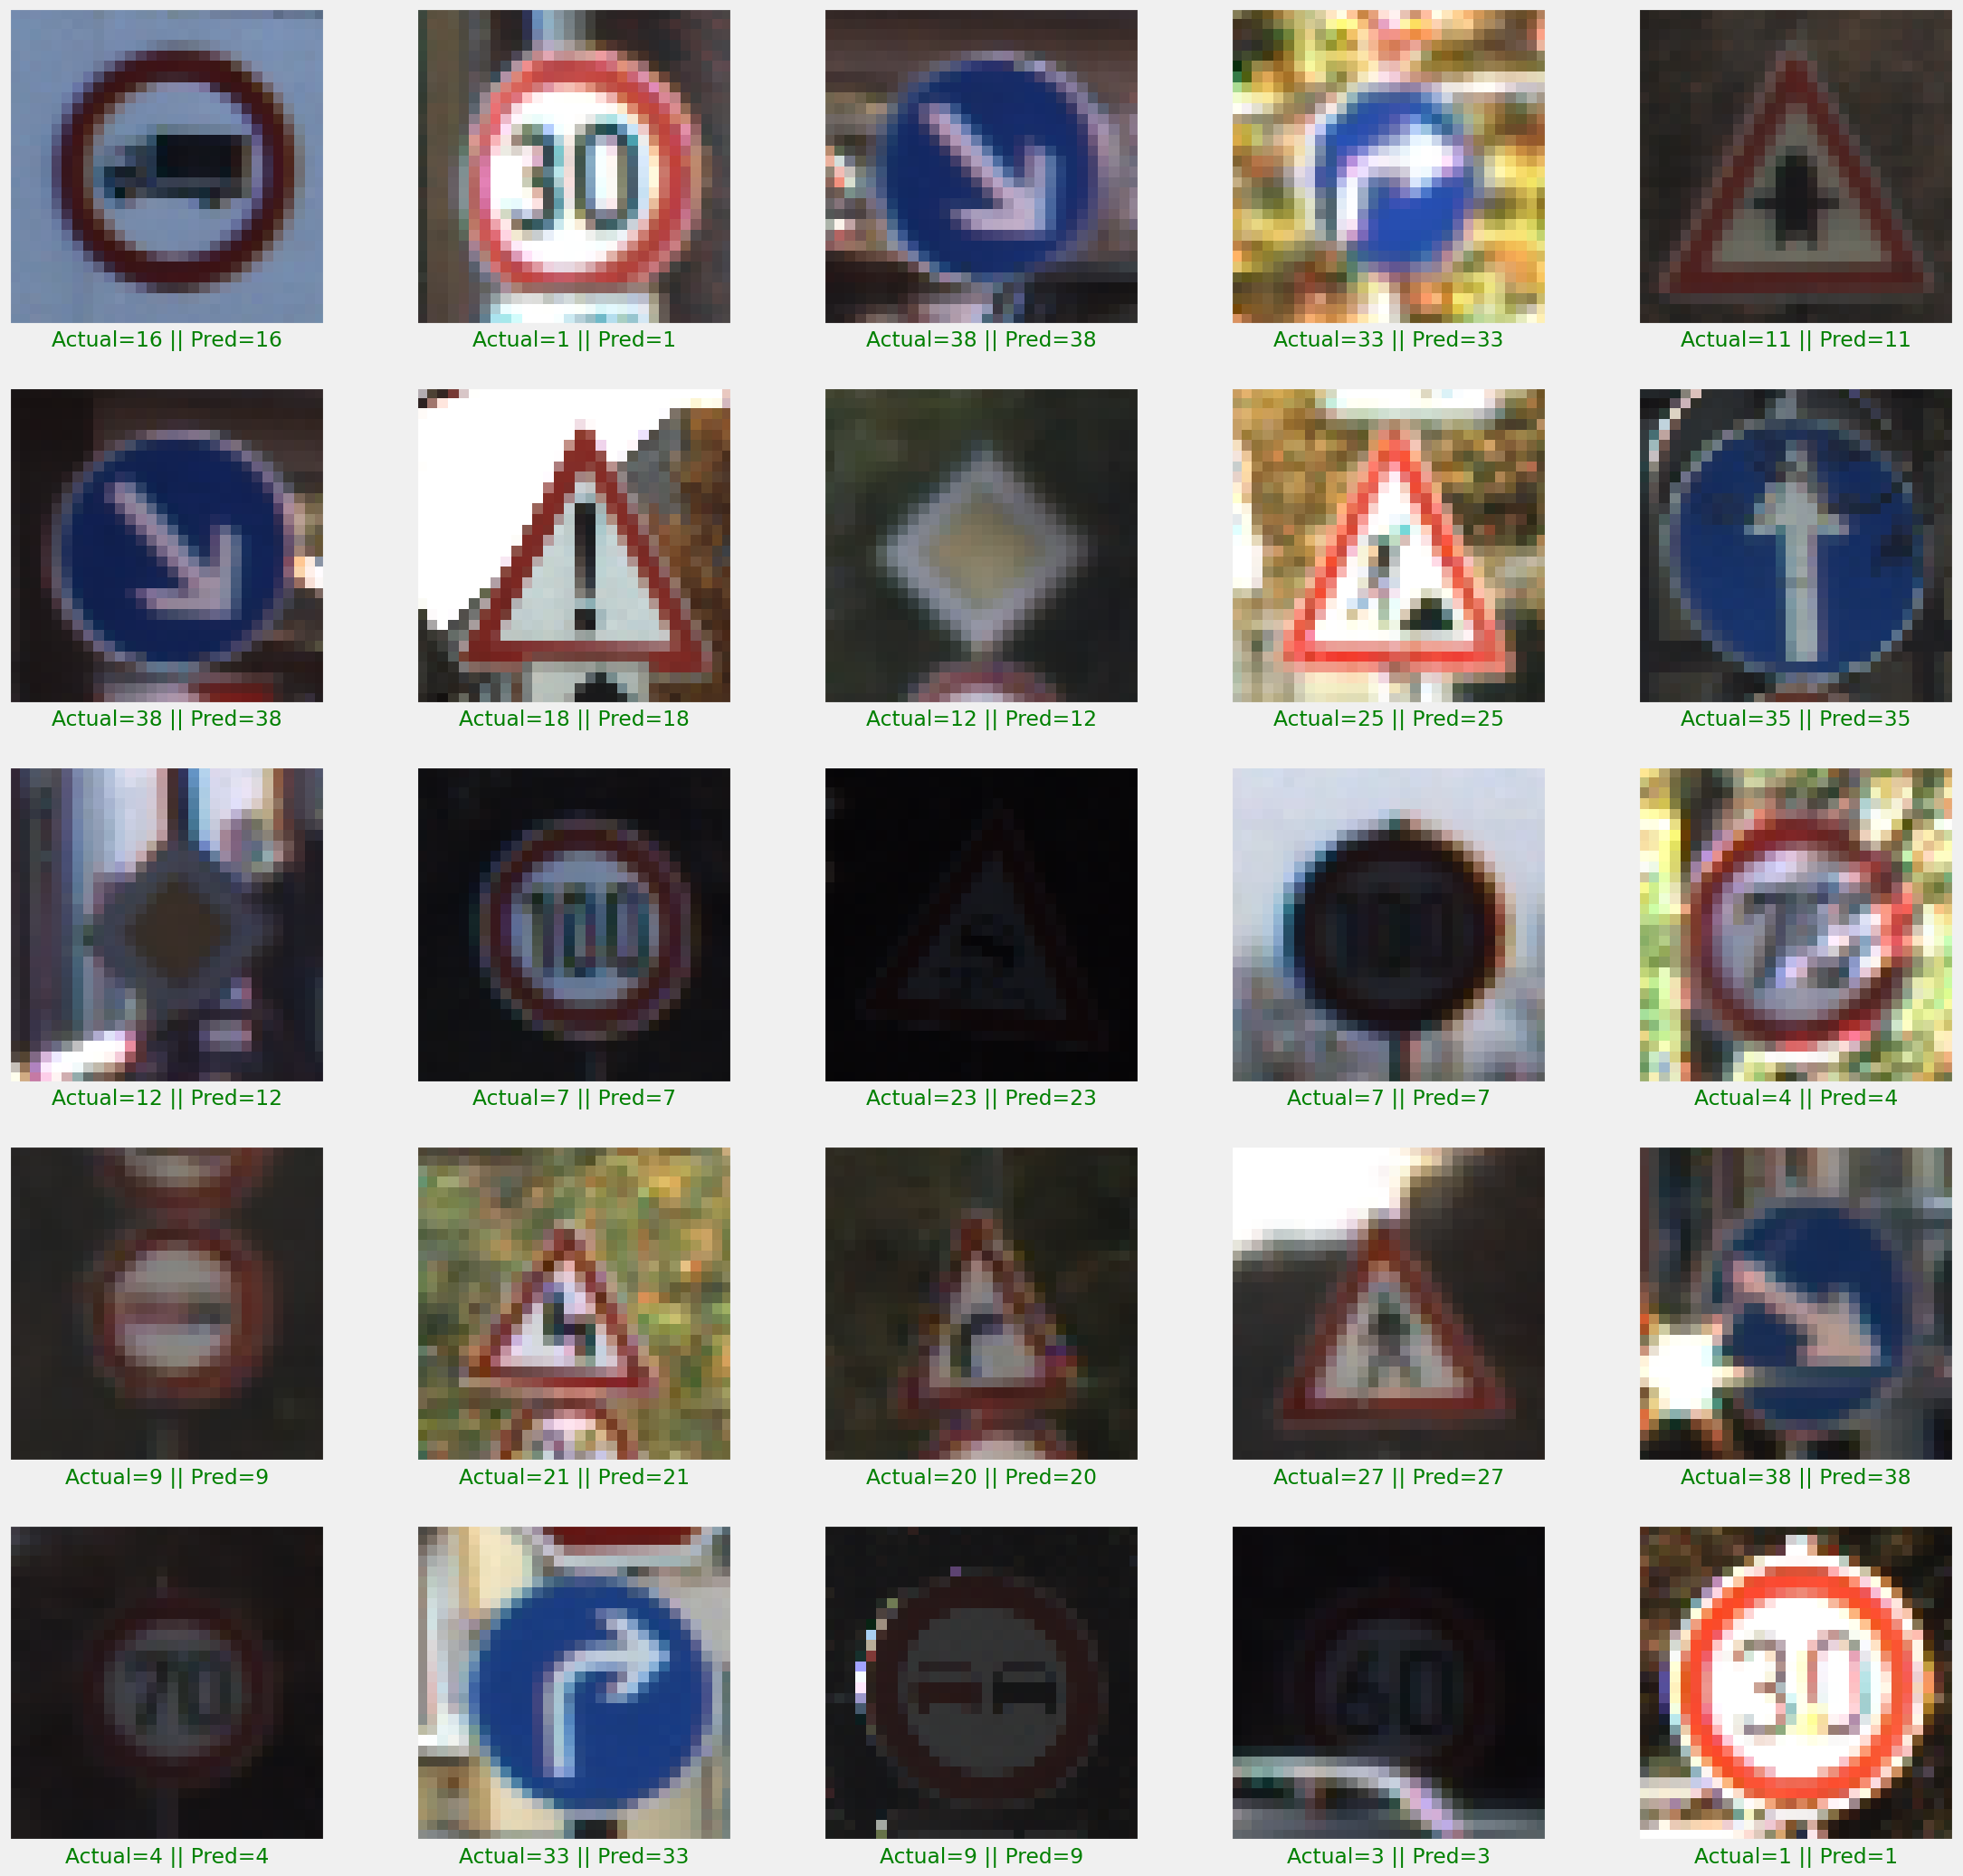

In [19]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [20]:
model.save('tsr_model')
print("Saved Model")

INFO:tensorflow:Assets written to: tsr_model\assets


INFO:tensorflow:Assets written to: tsr_model\assets


Saved Model


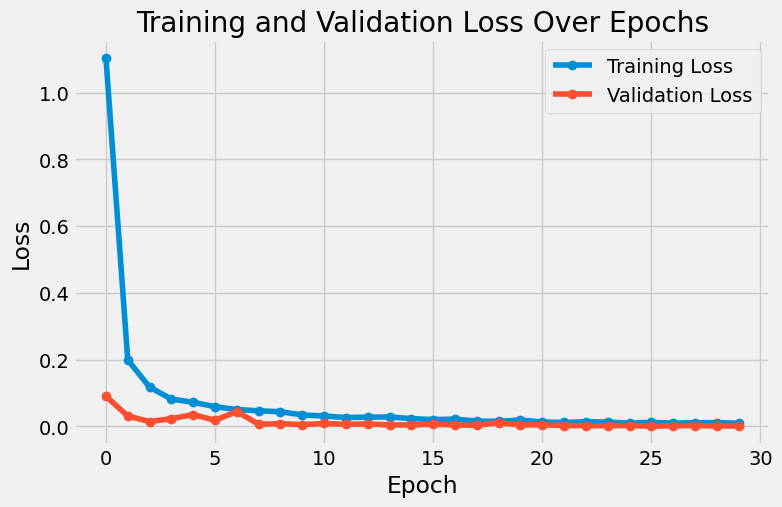

In [24]:
# Create a Pandas DataFrame from the history dictionary
history_df = pd.DataFrame(history.history)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Training Loss', marker='o')
plt.plot(history_df['val_loss'], label='Validation Loss', marker='o')

# Add titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

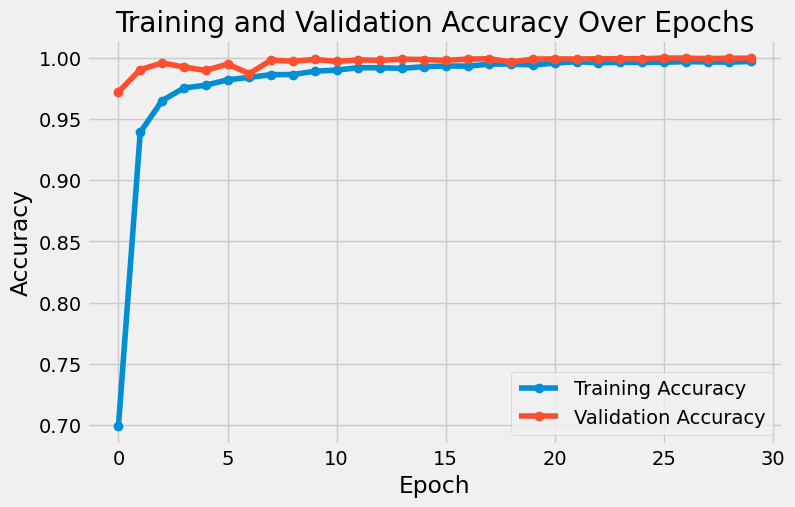

In [26]:
# Create a Pandas DataFrame from the history dictionary
history_df = pd.DataFrame(history.history)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(history_df['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', marker='o')

# Add titles and labels
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
